In [3]:
import sys
import os

sys.path.append("/Users/mb279434/Documents/stage/repos/argosim/src")

# PSO for Y configuration

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.spatial.distance import pdist

# Parameter
antennas_per_arm = 5
max_radius = 1000.0      
dim = antennas_per_arm
bounds = (0.1, max_radius - 0.1)

num_particles = 6
num_iterations = 10
w, c1, c2 = 0.9, 2, 2
grid_size = (128, 128)

# Y-array configuration : construction of the Y-array  because the argosim function isn't suitable for this optimization
def build_y_array(distances):
    angles = [0, 120, 240]
    coords = []
    distances = np.clip(distances, bounds[0], bounds[1])
    distances = np.unique(np.round(distances, 4))

    while len(distances) < antennas_per_arm:
        new_d = np.round(np.random.uniform(bounds[0], bounds[1]), 4)
        if not np.any(np.isclose(distances, new_d, atol=0.01)):
            distances = np.append(distances, new_d)
            distances = np.unique(np.round(distances, 4))
    distances = np.sort(distances)

    for angle in angles:
        theta = np.deg2rad(angle)
        for r in distances:
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            coords.append([x, y])
    return np.array(coords)

# UV coverage
def compute_uv(array):
    uv = []
    for i, j in combinations(range(len(array)), 2):
        dx, dy = array[j] - array[i]
        uv.append([dx, dy])
        uv.append([-dx, -dy])
    return np.array(uv)

# Fitness 
def fitness(distances):
    arr = build_y_array(distances)
    uv = compute_uv(arr)
    hist, _, _ = np.histogram2d(uv[:, 0], uv[:, 1], bins=grid_size)
    return -np.count_nonzero(hist)  

# PSO initialization
positions = np.random.uniform(bounds[0], bounds[1], (num_particles, dim))
velocities = np.zeros_like(positions)
p_best = positions.copy()
p_best_fitness = np.array([fitness(p) for p in p_best])
g_best = p_best[np.argmin(p_best_fitness)]
g_best_fitness = np.min(p_best_fitness)

# Storage for plots
all_positions = []
all_p_bests = []
all_g_bests = []

# LOOP PSO 
for iter_num in range(num_iterations):
    all_positions.append(positions.copy())
    all_p_bests.append(p_best.copy())
    all_g_bests.append(g_best.copy())

    for i in range(num_particles):
        fit = fitness(positions[i])
        if fit < p_best_fitness[i]:
            p_best[i] = positions[i]
            p_best_fitness[i] = fit
        if fit < g_best_fitness:
            g_best = positions[i]
            g_best_fitness = fit

    r1 = np.random.rand(num_particles, dim)
    r2 = np.random.rand(num_particles, dim)
    velocities = w * velocities + c1 * r1 * (p_best - positions) + c2 * r2 * (g_best - positions)
    positions += velocities
    positions = np.clip(positions, bounds[0], bounds[1])

# Display for optimized configuration
final_array = build_y_array(g_best)
uv = compute_uv(final_array)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(final_array[:, 0], final_array[:, 1], c='blue')
axes[0].set_title("Optimized Y-array")
axes[0].set_xlabel("X (km)")
axes[0].set_ylabel("Y (km)")
axes[0].axis("equal")
axes[0].grid(True)

axes[1].scatter(uv[:, 0], uv[:, 1], c='red', s=10)
axes[1].set_title("u-v Coverage")
axes[1].set_xlabel("u (km)")
axes[1].set_ylabel("v (km)")
axes[1].axis("equal")
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Display of the PSO process over 10 iterations
colors = plt.cm.tab10(np.linspace(0, 1, num_particles))

for iter_num in range(min(10, num_iterations)):
    fig, ax = plt.subplots(figsize=(6, 6))
    for i in range(num_particles):
        arr = build_y_array(all_positions[iter_num][i])
        p_arr = build_y_array(all_p_bests[iter_num][i])
        ax.scatter(arr[:, 0], arr[:, 1], label=f"Particle {i+1}", c=[colors[i]], alpha=0.5)
        ax.scatter(p_arr[:, 0], p_arr[:, 1], marker='x', c=[colors[i]], alpha=0.7)

    g_arr = build_y_array(all_g_bests[iter_num])
    ax.scatter(g_arr[:, 0], g_arr[:, 1], marker='*', color='red', s=100, label="G_best")

    ax.set_title(f"PSO Iteration {iter_num+1}")
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.axis("equal")
    ax.grid(True)
    ax.legend(fontsize=8, loc='upper right')
    plt.show()


- Optimized version with dynamic inertia weight (w) from 0.9 to 0.4


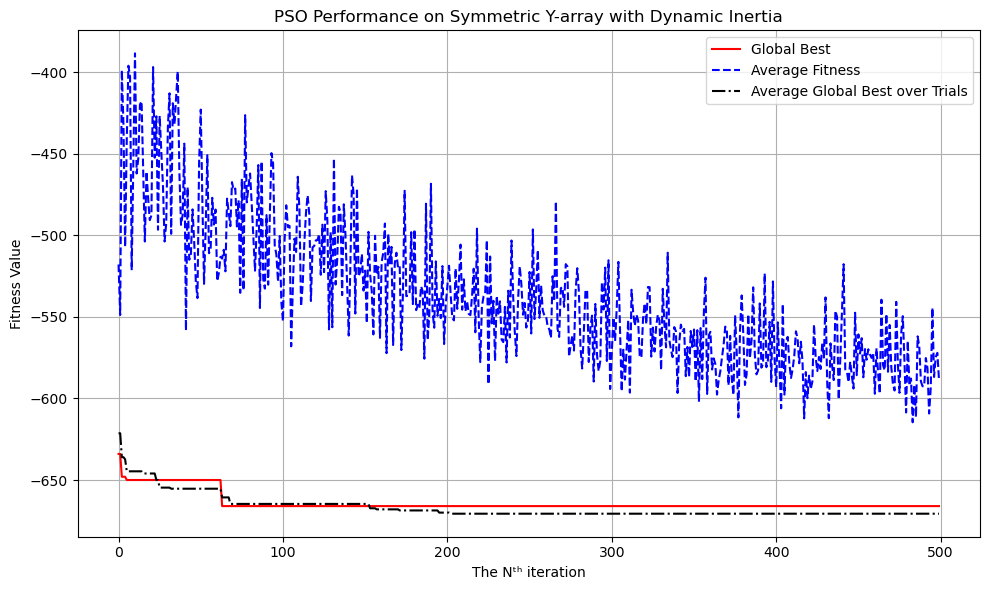

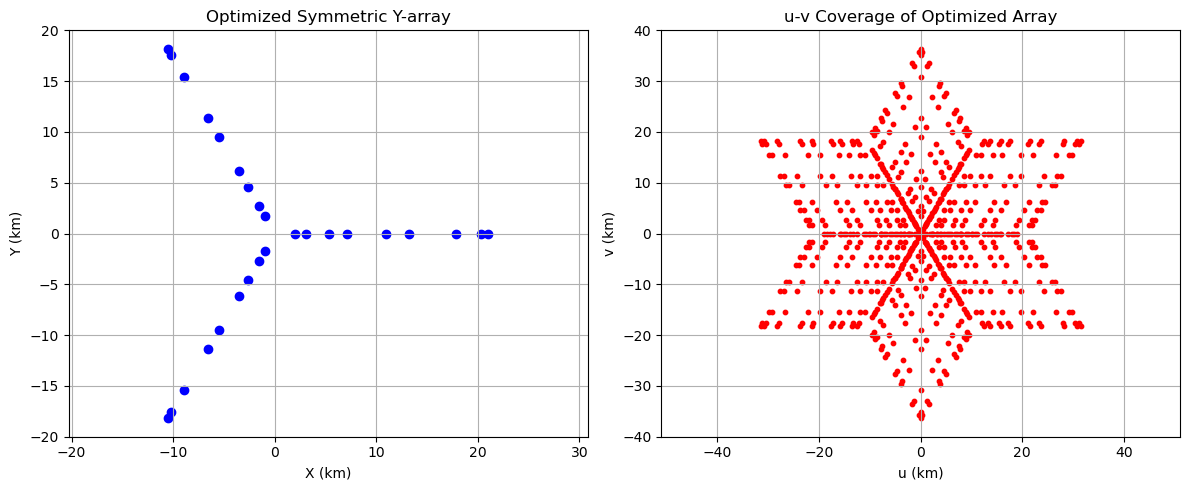

In [ ]:
#  Parameters
antennas_per_arm = 9
dim = antennas_per_arm
arm_angles_deg = [0, 120, 240]
max_distance = 21.0
bounds = (2.0, max_distance)
num_particles = 10
num_iterations = 500  
num_trials = 3
w_max, w_min = 0.9, 0.4
c1, c2 = 2, 2
grid_size = (128, 128)  

#  Y-array
def build_y_array(distances):
    coords = []
    distances = np.clip(distances, bounds[0], bounds[1])
    distances = np.sort(distances)
    for angle_deg in arm_angles_deg:
        theta = np.deg2rad(angle_deg)
        for r in distances:
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            coords.append([x, y])
    return np.array(coords)

#  UV coverage 
def compute_uv(array):
    uv = []
    for i, j in combinations(range(len(array)), 2):
        dx, dy = array[j] - array[i]
        uv.append([dx, dy])
        uv.append([-dx, -dy])
    return np.array(uv)

# Fitness
def fitness(distances):
    arr = build_y_array(distances)
    uv = compute_uv(arr)
    hist, _, _ = np.histogram2d(uv[:, 0], uv[:, 1], bins=grid_size)
    return -np.count_nonzero(hist)  

# Storage for plotting  
all_g_best_fitness_trials = []
all_avg_fitness_trials = []

# Trial
for trial in range(num_trials):
    positions = np.random.uniform(bounds[0], bounds[1], (num_particles, dim))
    velocities = np.zeros_like(positions)
    p_best = positions.copy()
    p_best_fitness = np.array([fitness(p) for p in p_best])
    g_best = p_best[np.argmin(p_best_fitness)].copy()
    g_best_fitness = np.min(p_best_fitness)

    g_best_progression = []
    avg_fitness_progression = []

    for iteration in range(num_iterations):
        # decreasing inertia (w)
        w = w_max - ((w_max - w_min) * iteration / num_iterations)

        current_fitness = np.array([fitness(p) for p in positions])
        avg_fitness_progression.append(np.mean(current_fitness))
        g_best_progression.append(g_best_fitness)

        for i in range(num_particles):
            if current_fitness[i] < p_best_fitness[i]:
                p_best[i] = positions[i]
                p_best_fitness[i] = current_fitness[i]

        best_idx = np.argmin(p_best_fitness)
        if p_best_fitness[best_idx] < g_best_fitness:
            g_best = p_best[best_idx].copy()
            g_best_fitness = p_best_fitness[best_idx]

        r1 = np.random.rand(num_particles, dim)
        r2 = np.random.rand(num_particles, dim)
        velocities = w * velocities + c1 * r1 * (p_best - positions) + c2 * r2 * (g_best - positions)
        positions += velocities
        positions = np.clip(positions, bounds[0], bounds[1])

    all_g_best_fitness_trials.append(g_best_progression)
    all_avg_fitness_trials.append(avg_fitness_progression)

# Plot fitness 
mean_g_best = np.mean(all_g_best_fitness_trials, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(all_g_best_fitness_trials[0], label="Global Best", color="red")
plt.plot(all_avg_fitness_trials[0], label="Average Fitness", linestyle="--", color="blue")
plt.plot(mean_g_best, label="Average Global Best over Trials", linestyle="dashdot", color="black")
plt.xlabel("The Nᵗʰ iteration")
plt.ylabel("Fitness Value")
plt.title("PSO Performance on Symmetric Y-array with Dynamic Inertia")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#  Display array and uv coverage 
final_array = build_y_array(g_best)
uv_points = compute_uv(final_array)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(final_array[:, 0], final_array[:, 1], color='blue')
axes[0].set_title("Optimized Symmetric Y-array")
axes[0].set_xlabel("X (km)")
axes[0].set_ylabel("Y (km)")
axes[0].axis("equal")
axes[0].grid(True)

axes[1].scatter(uv_points[:, 0], uv_points[:, 1], color='red', s=10)
axes[1].set_title("u-v Coverage of Optimized Array")
axes[1].set_xlabel("u (km)")
axes[1].set_ylabel("v (km)")
axes[1].axis("equal")
axes[1].grid(True)

plt.tight_layout()
plt.show()


# PSO for random configuration

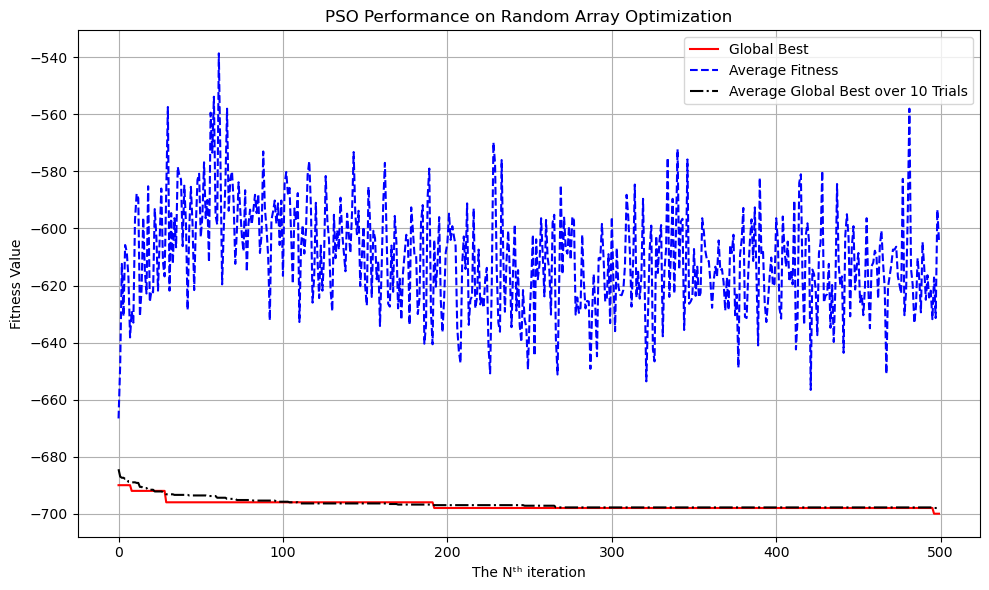

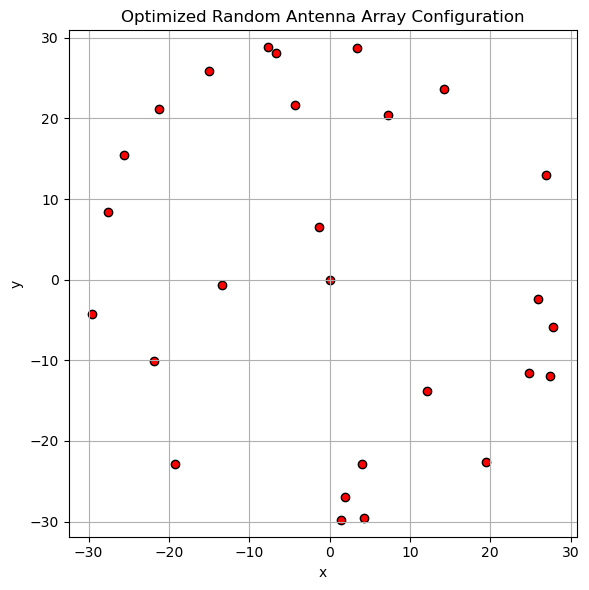

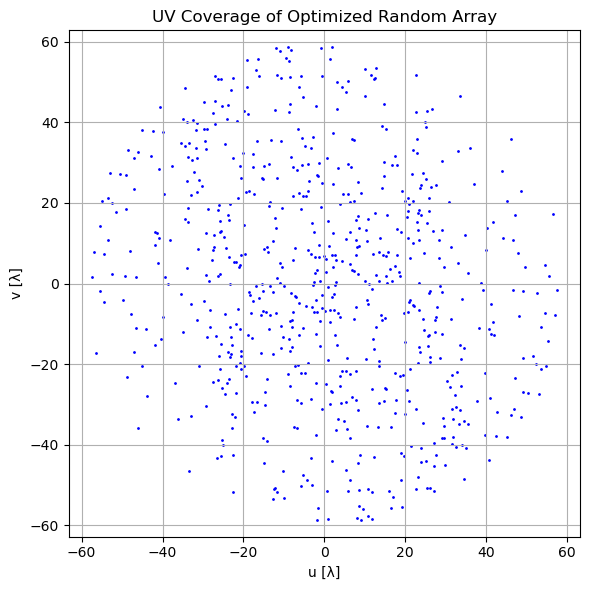

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Parameters
num_antennas = 27
max_radius = 30.0
bounds = (0.1, max_radius - 0.1)

num_particles = 10
num_iterations = 500
num_trials = 10
w, c1, c2 = 0.9, 2, 2
grid_size = (128, 128)

# Random configuration
def build_random_array(positions):
    r = np.clip(positions, bounds[0], bounds[1])
    angles = np.random.uniform(0, 2 * np.pi, size=num_antennas)
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    return np.column_stack((x, y))

#  UV coverage 
def compute_uv(array):
    uv = []
    for i, j in combinations(range(len(array)), 2):
        dx, dy = array[j] - array[i]
        uv.append([dx, dy])
        uv.append([-dx, -dy])
    return np.array(uv)

# Fitness fonction
def fitness(positions):
    arr = build_random_array(positions)
    uv = compute_uv(arr)
    hist, _, _ = np.histogram2d(uv[:, 0], uv[:, 1], bins=grid_size)
    return -np.count_nonzero(hist)  

# Storage for plotting
all_g_best_fitness_trials = []
all_avg_fitness_trials = []

# TRIAL 
for trial in range(num_trials):
    positions = np.random.uniform(bounds[0], bounds[1], (num_particles, num_antennas))
    velocities = np.zeros_like(positions)
    p_best = positions.copy()
    p_best_fitness = np.array([fitness(p) for p in p_best])
    g_best = p_best[np.argmin(p_best_fitness)].copy()
    g_best_fitness = np.min(p_best_fitness)

    g_best_progression = []
    avg_fitness_progression = []

    for _ in range(num_iterations):
        current_fitness = np.array([fitness(p) for p in positions])
        avg_fitness_progression.append(np.mean(current_fitness))
        g_best_progression.append(g_best_fitness)

        for i in range(num_particles):
            if current_fitness[i] < p_best_fitness[i]:
                p_best[i] = positions[i]
                p_best_fitness[i] = current_fitness[i]

        best_idx = np.argmin(p_best_fitness)
        if p_best_fitness[best_idx] < g_best_fitness:
            g_best = p_best[best_idx].copy()
            g_best_fitness = p_best_fitness[best_idx]

        r1 = np.random.rand(num_particles, num_antennas)
        r2 = np.random.rand(num_particles, num_antennas)
        velocities = w * velocities + c1 * r1 * (p_best - positions) + c2 * r2 * (g_best - positions)
        positions += velocities
        positions = np.clip(positions, bounds[0], bounds[1])

    all_g_best_fitness_trials.append(g_best_progression)
    all_avg_fitness_trials.append(avg_fitness_progression)

# PLOT
mean_g_best = np.mean(all_g_best_fitness_trials, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(all_g_best_fitness_trials[0], label="Global Best", color="red")
plt.plot(all_avg_fitness_trials[0], label="Average Fitness", linestyle="--", color="blue")
plt.plot(mean_g_best, label="Average Global Best over 10 Trials", linestyle="dashdot", color="black")
plt.xlabel("The Nᵗʰ iteration")
plt.ylabel("Fitness Value")
plt.title("PSO Performance on Random Array Optimization")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Display random array
final_array = build_random_array(g_best)

plt.figure(figsize=(6, 6))
plt.scatter(final_array[:, 0], final_array[:, 1], c='red', edgecolors='black')
plt.title("Optimized Random Antenna Array Configuration")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

# Dsiplay uv coverage of optimized random array 
uv_points = compute_uv(final_array)

plt.figure(figsize=(6, 6))
plt.scatter(uv_points[:, 0], uv_points[:, 1], s=1, color='blue')
plt.title("UV Coverage of Optimized Random Array")
plt.xlabel("u [λ]")
plt.ylabel("v [λ]")
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()
